<a href="https://colab.research.google.com/github/Mai-Binh-Nam/Hand-on_DataAnalysisVEF/blob/master/Logistics_Regression_and_Tree_based_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression


Demo of Logistic Regression on Breast cancer dataset

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, field
        13 is Radius SE, field 23 is Worst Radius.

        - class:
                - WDBC-Malignant
                - WDBC-Benign

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, \
                            roc_auc_score, plot_roc_curve

## 1. Data Loading & PreProcessing

In [ ]:
# Load data
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

In [ ]:
# Scaling the features using Min-Max scaler
X = data['data']
scl = MinMaxScaler()
scl.fit(X)
X_scaled = scl.transform(X)

In [ ]:
y = data['target']

In [ ]:
# Split data into train-test with ratio 60:40
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=0)

In [ ]:
X_train.shape

(341, 30)

In [ ]:
X_test.shape

(228, 30)

## 2. Model training

In [ ]:
# Initiate the Logistic regression model and fit the data
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

## 3. Results

In [ ]:
# Print the metrics of classifier
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.87      0.92        83
           1       0.93      0.99      0.96       145

    accuracy                           0.95       228
   macro avg       0.96      0.93      0.94       228
weighted avg       0.95      0.95      0.95       228



In [ ]:
# Print the AUC score
y_score = logreg.decision_function(X_test)
auc_score = roc_auc_score(y_test, y_score)
print(f"AUC = {auc_score}")

AUC = 0.9902783547985043


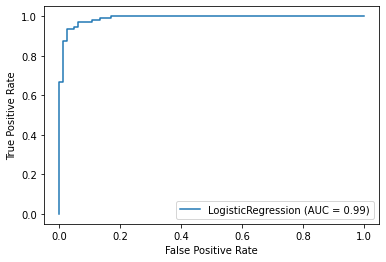

In [ ]:
# Plot the ROC
plot_roc_curve(logreg, X_test, y_test)

# Predicting Bankruptcy using Logistic Regression


## 1. Data loading
The data consist of 64 financial ratio & 1 label (0 - no bankruptcy & 1 - bankruptcy after 5 years)

The NA values in data set were marked as "?" which will be imputed by 0 later.

List of attributes:

* X1 net profit / total assets
* X2 total liabilities / total assets
* X3 working capital / total assets
* X4 current assets / short-term liabilities
* X5 [(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365
* ...

More info: https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data

In [ ]:
# Data loading
data_link = 'https://github.com/pnhuy/datasets/raw/master/polish_bankruptcy/1st_year.csv'
df_bankruptcy = pd.read_csv(data_link, na_values=['?'])

In [ ]:
df_bankruptcy.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr37,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,0.249760,0.65980,0.166600,0.249760,497.42,0.73378,2.6349,0.249760,0.149420,43.370,1.2479,0.21402,0.119980,0.47706,0.50494,0.60411,1.45820,1.7615,5.9443,0.11788,0.149420,94.14,3.8772,0.56393,0.21402,1.7410,593.2700,0.50591,0.128040,0.662950,0.051402,0.128040,114.42,71.050,1.00970,1.52250,49.394,0.185300,0.110850,2.0420,0.37854,0.25792,2.2437,2.2480,348690.0,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,0
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,0.261140,0.51680,0.158350,0.258340,677.96,0.53838,2.0005,0.258340,0.152000,87.981,1.4293,0.24806,0.123040,NaN,0.39542,0.43992,88.44400,16.9460,3.6884,0.26969,0.152000,122.17,2.9876,2.98760,0.20616,1.6996,NaN,0.49788,0.121300,0.086422,0.064371,0.145950,199.49,111.510,0.51045,1.12520,100.130,0.237270,0.139610,1.9447,0.49988,0.33472,17.8660,17.8660,2304.6,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,0
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,0.312580,0.64184,0.244350,0.309060,794.16,0.45961,1.4369,0.309060,0.236100,73.133,1.4283,0.30260,0.189960,NaN,0.28932,0.37282,86.01100,1.0627,4.3749,0.41929,0.238150,176.93,2.0630,1.42740,0.31565,1.3090,2.3019,0.51537,0.241140,0.322020,0.074020,0.231170,165.51,92.381,0.94807,1.01010,96.372,0.291810,0.222930,1.0758,0.48152,0.48474,1.2098,2.0504,6332.7,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,0
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,0.092704,0.30163,0.094257,0.092704,917.01,0.39803,3.2537,0.092704,0.071428,79.788,1.5069,0.11550,0.062782,0.17193,0.57353,0.36152,0.94076,1.9618,4.6511,0.14343,0.071428,91.37,3.9948,0.37581,0.11550,1.3562,NaN,0.57353,0.088995,0.401390,0.069622,0.088995,180.77,100.980,0.28720,1.56960,84.344,0.085874,0.066165,2.4928,0.30734,0.25033,2.4524,2.4524,20545.0,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,0
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,0.187320,0.33147,0.121820,0.187320,1133.20,0.32211,1.6307,0.187320,0.115530,57.045,NaN,0.19832,0.115530,0.18732,0.38677,0.32211,1.41380,1.1184,4.1424,0.27884,0.115530,147.04,2.4823,0.32340,0.19832,1.6278,11.2470,0.43489,0.122310,0.293040,0.096680,0.122310,141.62,84.574,0.73919,0.95787,65.936,0.188110,0.116010,1.2959,0.56511,0.40285,1.8839,2.1184,3186.6,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,0


In [ ]:
df_bankruptcy['class'].value_counts()

0    6756
1     271
Name: class, dtype: int64

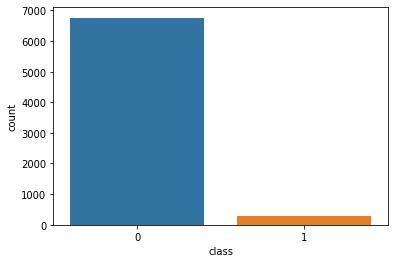

In [ ]:
sns.countplot(x="class", data=df_bankruptcy)

The distribution of label was extremely imbalanced

## 2. Data preprocessing

* NA filling by 0
* Standard scaling
* Train-test splitting


In [ ]:
# The NA in X dataframe was imputed by Zero
X = df_bankruptcy.drop(columns=['class']).fillna(0)
y = df_bankruptcy['class']

In [ ]:
# Scaling the features matrix by Standard scaling
scl = StandardScaler()
scl.fit(X)
X_scaled = scl.transform(X) 

In [ ]:
# Split the data into train and test dataset with the ratio 60:40
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y , test_size=0.4)

## 3. Hyperparameter Optimization using Grid Search

In [ ]:
# Initiate the Logistic Regression model
logreg = LogisticRegression()

In [ ]:
"""
Define the hyperparameter space
:params: penalty: Regularization method
:params: C: Regularization term, detail here: 
            https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
:params: solver: optimization algorithms
:params: class_weight: The “balanced” mode uses the values of y to automatically 
                       adjust weights inversely proportional to class frequencies 
                       in the input data as n_samples / (n_classes * np.bincount(y)).
"""
param_grid = {
    'penalty': ['l1', 'l2'], 
    'C': [-4, -2, -1, -0.5, 0.5, 1, 2, 4],
    'solver': ['lbfgs', 'liblinear'],
    'class_weight': ['balanced']
}

In [ ]:
# Initiate the Gridsearch with Cross-validation
grid = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc', verbose=True, n_jobs=-1)

In [ ]:
# Fit the data and hyperparameter space to the model 
# and benchmark to find out the best classifier
# ~ 5 min in Colab
best_clf = grid.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  5.3min finished
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
# Showing the best params set
best_clf.best_params_

{'C': 2, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}

## 4. Results

In [ ]:
clf = best_clf.best_estimator_
clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=2, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Calculate the prediction in test set
y_pred = clf.predict(X_test)

In [ ]:
# Print the metrics on test set
print(accuracy_score(y_test, y_pred))

0.6627534685165422


In [ ]:
# Print the AUC score
y_score = clf.decision_function(X_test)
auc_score = roc_auc_score(y_test, y_score)
print(f"AUC = {auc_score}")

AUC = 0.7265490895627881


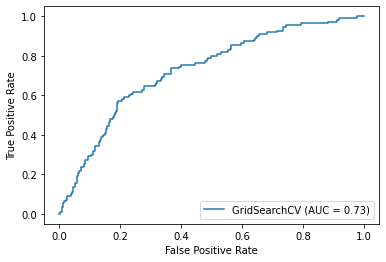

In [ ]:
# Plot the ROC 
plot_roc_curve(best_clf, X_test, y_test)

# Decision Tree

In [ ]:
X = data['data']
y = data['target']
feature_names = data['feature_names']
target_names = data['target_names']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

dtc = DecisionTreeClassifier(max_depth=3)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
y_pred = dtc.predict(X_test)

In [ ]:
print(accuracy_score(y_test, y_pred))

0.9230769230769231


In [ ]:
# Print the AUC score
y_score = dtc.predict_proba(X_test)
auc_score = roc_auc_score(y_test, y_score[:,1])
print(f"AUC = {auc_score}")

AUC = 0.9513626834381552


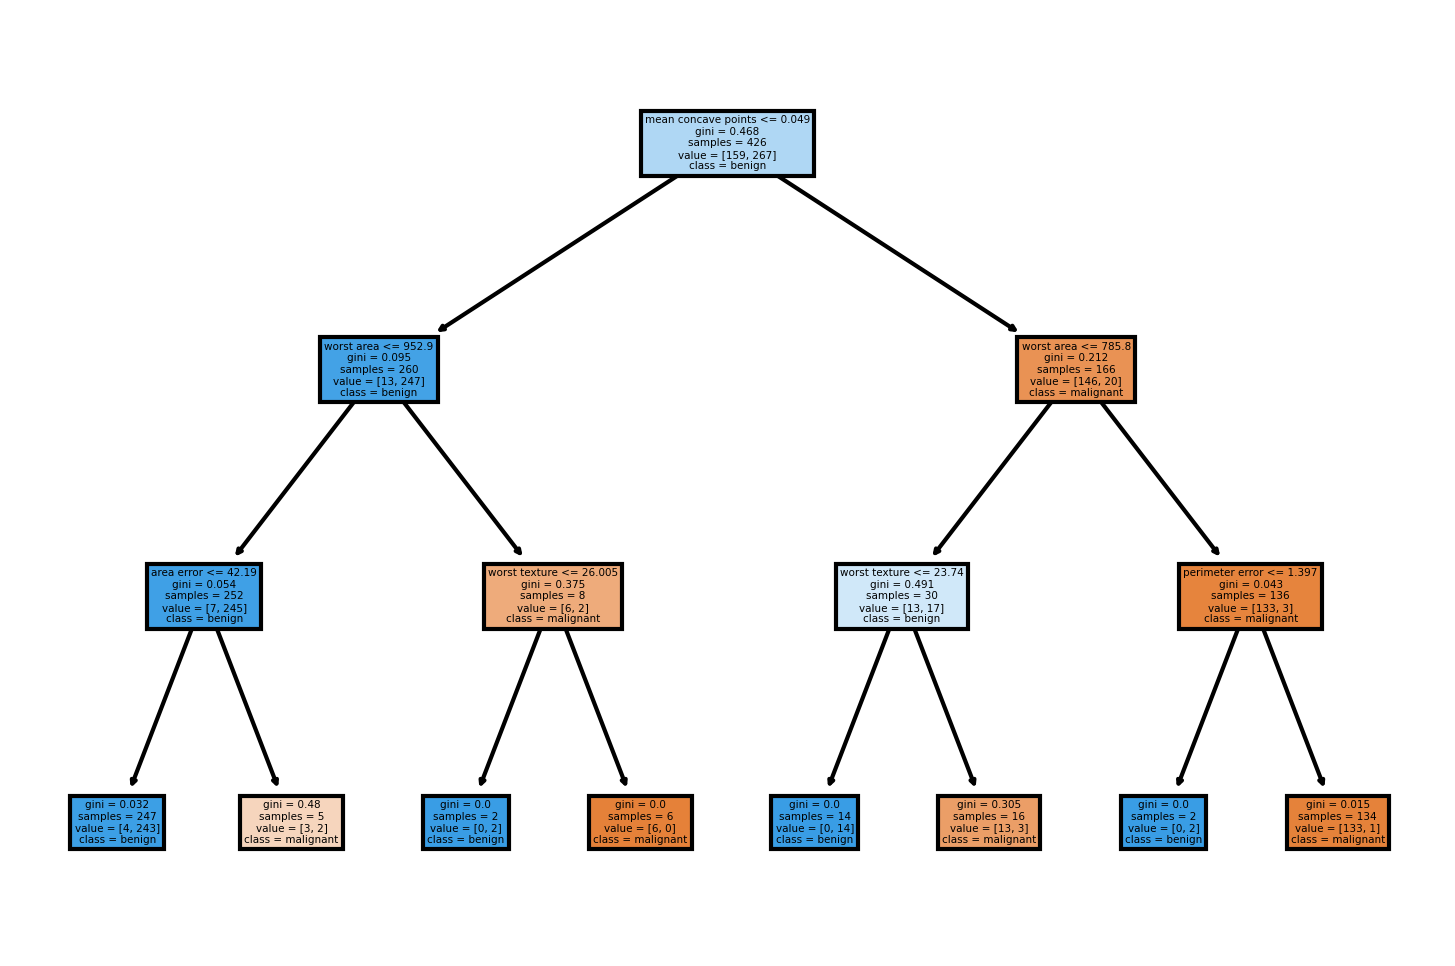

In [ ]:
fig, axes = plt.subplots(dpi=300)
plot_tree(dtc, feature_names=feature_names, class_names=target_names, filled = True)
fig.show()

# Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [ ]:
print(accuracy_score(y_test, y_pred))

0.9790209790209791


In [ ]:
# Print the AUC score
y_score = rf.predict_proba(X_test)
auc_score = roc_auc_score(y_test, y_score[:,1])
print(f"AUC = {auc_score}")

AUC = 0.9966457023060796
